In [55]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from torchvision.datasets import MNIST
from torchvision import transforms
from torch.utils.data import DataLoader
plt.rcParams['figure.figsize'] = (8, 8)

In [ ]:
## Data loading and transforming
BATCH_SIZE = 120

#Transformation
transform = transforms.Compose([transforms.ToTensor()])

#Downloading and Loading training and test dataset
train_data = torchvision.datasets.MNIST(root='./data', train=True, download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(train_data, batch_size=BATCH_SIZE, shuffle=True, num_workers=2)

test_data = torchvision.datasets.MNIST(root='./data', train=False, download=True, transform=transform)
testloader = torch.utils.data.DataLoader(test_data, batch_size=BATCH_SIZE, shuffle=True, num_workers=2)


  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw



In [ ]:
##Find the shape of input image
images, labels = next(iter(trainloader))
images.shape

torch.Size([120, 1, 28, 28])

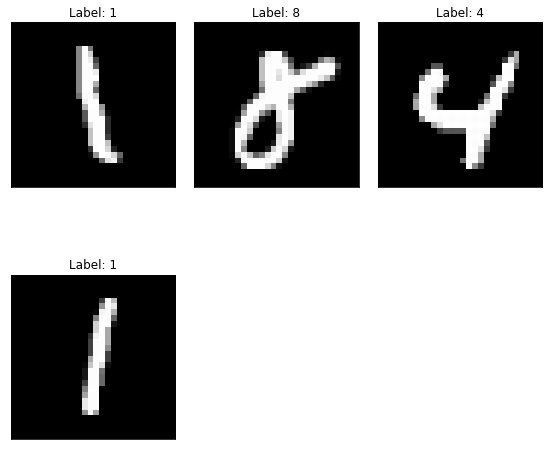

In [ ]:
fig = plt.figure()
for i in range(4):
  plt.subplot(2,3,i+1)
  plt.tight_layout()
  plt.imshow(images[i][0], cmap='gray', interpolation='none')
  plt.title("Label: {}".format(labels[i]))
  plt.xticks([])
  plt.yticks([])


In [ ]:
# Check if Gpu is available
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

# Configure the hyperparameters
num_epochs = 4
num_classes = 10
learning_rate = 0.001

In [ ]:
device 

device(type='cuda', index=0)

In [ ]:
print('Length of train data is: {}'.format(len(train_data)))
print('Length of test data is: {}'.format(len(test_data)))

Length of train data is: 60000
Length of test data is: 10000


In [ ]:
# Convolutional neural network (two block convolutional network)
class Custom_cnn(nn.Module):
    def __init__(self, num_classes=10):
        super(Custom_cnn, self).__init__()
        self.block1 = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=5, stride=1, padding=2),
            #in_channels=, out_channels=, kernel_size=, stride=, padding=
            nn.Conv2d(32, 64, kernel_size=5, stride=1, padding=2),
            nn.BatchNorm2d(64),
            nn.ReLU())
        self.block2 = nn.Sequential(
            nn.Conv2d(64,128 , kernel_size=5, stride=1, padding=2),
            nn.Conv2d(128, 256, kernel_size=5, stride=1, padding=2),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2))
        self.drop_out = nn.Dropout()
        #self.fc1 = nn.Linear(14* 14* 256, 1000)
        self.fc = nn.Linear(14* 14* 256, 10)
        #self.fc2 = nn.Linear(1000, 500)
        #self.fc3= nn.Linear(500, 10)
    def forward(self, x):
        out = self.block1(x)
        out = self.block2(out)
        out = out.reshape(out.size(0), -1)
        out = self.drop_out(out)
        out = self.fc(out)
        #out = self.fc1(out)
        #out = self.fc2(out)
        #out = self.fc3(out)
        return out
    
    
model = Custom_cnn(num_classes).to(device)

In [ ]:
# Loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

# Train the model
total_step = len(trainloader)
all_losses = []

for epoch in range(num_epochs):
  ith_epoch_loss = 0.0
  for i, (images, labels) in enumerate(trainloader):
    images = images.to(device)
    labels = labels.to(device)

    #Forward propagation
    outputs = model(images)
    loss = criterion(outputs, labels)

    # Backward and optimize
    #zero the parameter gradients
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    ith_epoch_loss += loss.item()
    if (i+1) % 100 == 0:
      print ('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}'.format(epoch+1, num_epochs, i+1, total_step, loss.item()))
      all_losses .append(ith_epoch_loss/ BATCH_SIZE)
      ith_epoch_loss = 0.0


Epoch [1/4], Step [100/500], Loss: 0.3451
Epoch [1/4], Step [200/500], Loss: 0.1203
Epoch [1/4], Step [300/500], Loss: 0.0555
Epoch [1/4], Step [400/500], Loss: 0.3767
Epoch [1/4], Step [500/500], Loss: 0.2555
Epoch [2/4], Step [100/500], Loss: 0.2095
Epoch [2/4], Step [200/500], Loss: 0.0902
Epoch [2/4], Step [300/500], Loss: 0.2646
Epoch [2/4], Step [400/500], Loss: 0.6312
Epoch [2/4], Step [500/500], Loss: 0.4383
Epoch [3/4], Step [100/500], Loss: 0.2454
Epoch [3/4], Step [200/500], Loss: 0.0390
Epoch [3/4], Step [300/500], Loss: 0.1884
Epoch [3/4], Step [400/500], Loss: 0.0014
Epoch [3/4], Step [500/500], Loss: 0.0499
Epoch [4/4], Step [100/500], Loss: 0.0919
Epoch [4/4], Step [200/500], Loss: 0.0305
Epoch [4/4], Step [300/500], Loss: 0.0579
Epoch [4/4], Step [400/500], Loss: 0.1742
Epoch [4/4], Step [500/500], Loss: 0.0616


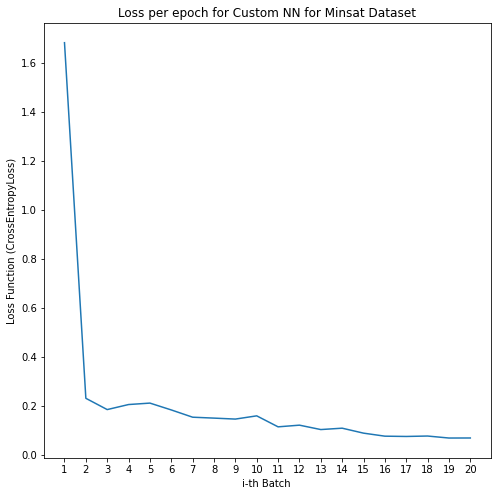

In [ ]:
plt.plot(all_losses)
plt.title("Loss per epoch for Custom NN for Minsat Dataset")
plt.ylabel("Loss Function (CrossEntropyLoss)")
plt.xlabel("i-th Batch ")
plt.xticks(np.arange(len(all_losses)), np.arange(1, len(all_losses)+1))
plt.show()

In [ ]:
def eval_model(trained_model,loader):
  classes = ('0','1', '2', '3', '4',
           '5', '6', '7', '8', '9' )
  correct_pred = {classname: 0 for classname in classes}
  all_pred = {classname: 0 for classname in classes}

  # again no gradients needed
  with torch.no_grad():
    overall_pred = 0
    total = 0
    for images, labels in loader:
        images = images.to(device)
        labels = labels.to(device)
        outputs = trained_model(images)
        _, predictions = torch.max(outputs, 1)
        total += labels.size(0)
        overall_pred += (predictions == labels).sum().item()

        # collect the correct predictions for each class
        for label, prediction in zip(labels, predictions):
            if label == prediction:
                correct_pred[classes[label]] += 1
            all_pred[classes[label]] += 1
            # print accuracy for each class
    print('Test Accuracy of the custom CNN model on the test images: {} %'.format(100 * overall_pred / total))
    print('##############################################################')
  for label_name, correct_count in correct_pred.items():
    accuracy = 100 * float(correct_count) / all_pred[label_name]
    print(f'Accuracy for class: {label_name:5s} is {accuracy:.1f} %')



In [ ]:
eval_model(model,testloader)

Test Accuracy of the custom CNN model on the test images: 98.55 %
##############################################################
Accuracy for class: 0     is 98.2 %
Accuracy for class: 1     is 99.6 %
Accuracy for class: 2     is 97.8 %
Accuracy for class: 3     is 98.3 %
Accuracy for class: 4     is 99.7 %
Accuracy for class: 5     is 99.9 %
Accuracy for class: 6     is 97.9 %
Accuracy for class: 7     is 97.1 %
Accuracy for class: 8     is 99.4 %
Accuracy for class: 9     is 97.7 %
